In [242]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.combine import SMOTEENN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns


In [243]:
def preprocess_data(df, dataset_name):
    """
    Preprocess input dataframe and return feature matrix X, target y, and sensitive attribute s
    Arguments:
        df: Raw input DataFrame
        dataset_name: One of ['adult', 'propublica', 'framingham']
    Returns:
        X, y, s: Processed features, target, and sensitive attribute
    """
    df = df.copy()
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()

    if dataset_name == 'adult':
        df.replace("?", np.nan, inplace=True)
        df.dropna(inplace=True)
        df['income'] = df['income'].apply(lambda x: 1 if '>50K' in x else 0)
        y = df['income'].values
    
        s = df['sex'].apply(lambda x: 1 if x.strip() == 'Male' else 0).values
        df.drop(['income', 'sex'], axis=1, inplace=True)

    elif dataset_name == 'propublica':  
        # Target
        y = df['Two_yr_Recidivism'].values
        # Sensitive attribute
        s = df['African_American'].values
        # Remove target and all race dummy variables from features
        race_columns = ['African_American', 'Asian', 'Hispanic', 'Native_American', 'Other']
        df.drop(['Two_yr_Recidivism'] + race_columns, axis=1, inplace=True)

    elif dataset_name == 'framingham':
        
        df.dropna(inplace=True)

        y = df['TenYearCHD'].values
        s = df['male'].values
        df.drop(['TenYearCHD', 'male'], axis=1, inplace=True)

    else:
        raise ValueError("Unsupported dataset_name. Use 'adult', 'propublica', or 'framingham'.")

    # Encode categorical columns
    for col in df.columns:
        if df[col].dtype == 'object' or isinstance(df[col].iloc[0], str):
            df[col] = le.fit_transform(df[col].astype(str))

    X = df.values
    return X, y, s, dataset_name

In [244]:
# ==========================
# BMNB Model Class
# ==========================
class BMNB:
    def __init__(self, alpha=0.5, class_priors=[0.5, 0.5]):
        self.alpha = alpha
        self.class_priors = class_priors
        self.group_models = {}
        self.thresholds = {}
        self.global_model = GaussianNB(priors=self.class_priors)

    def fit(self, X, y, sensitive):
        self.global_model.fit(X, y)
        self.groups = np.unique(sensitive)
        for group in self.groups:
            idx = (sensitive == group)
            model = GaussianNB(priors=self.class_priors)
            model.fit(X[idx], y[idx])
            self.group_models[group] = model

    def predict_proba(self, X, sensitive):
        global_probs = self.global_model.predict_proba(X)[:, 1]
        blended_probs = np.zeros(X.shape[0])
        for group in self.groups:
            idx = (sensitive == group)
            group_probs = self.group_models[group].predict_proba(X[idx])[:, 1]
            blended_probs[idx] = (
                self.alpha * global_probs[idx] + 
                (1 - self.alpha) * group_probs
            )
        return blended_probs

    def calibrate_thresholds(self, y_true, y_probs, sensitive):
        self.thresholds = {}
        target_rate = np.mean(y_true)
        for group in self.groups:
            group_probs = y_probs[sensitive == group]
            if len(group_probs) == 0:
                self.thresholds[group] = 0.5
                continue
            sorted_probs = np.sort(group_probs)
            target_idx = int((1 - target_rate) * len(sorted_probs))
            self.thresholds[group] = sorted_probs[-target_idx] if target_idx > 0 else 1.0

    def predict(self, X, sensitive):
        probs = self.predict_proba(X, sensitive)
        preds = np.zeros_like(probs, dtype=int)
        for group in self.groups:
            idx = (sensitive == group)
            if group in self.thresholds:
                preds[idx] = (probs[idx] >= self.thresholds[group]).astype(int)
        return preds

# ==========================
# BMNB Runner (Takes X, y, s directly)
# ==========================
def run_bmnb(X, y, s, dataset_name):
    # SMOTEENN
    sm = SMOTEENN(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X, y)

    print("✅ After SMOTEENN - X shape:", X_resampled.shape)
#     print("\n📊 Adult y values:")
#     print(np.unique(y))
#     print(dataset_name)
#     unique_values = np.unique(y)
#     print("Unique values:", unique_values)


    # Nearest neighbor match for sensitive attribute
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(X)
    _, indices = nn.kneighbors(X_resampled)
    sensitive_resampled = s[indices.flatten()]

    # Split the data
    X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
        X_resampled, y_resampled, sensitive_resampled,
        test_size=0.2, random_state=42, stratify=y_resampled
    )

    # Train BMNB
    model = BMNB(alpha=0.5, class_priors=[0.4, 0.6])
    model.fit(X_train, y_train, s_train)
    probs = model.predict_proba(X_test, s_test)
    model.calibrate_thresholds(y_test, probs, s_test)
    y_pred = model.predict(X_test, s_test)

    # === Performance Metrics ===
    print("\n📊 Performance Metrics for:", dataset_name)
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))

    # === Group Metrics ===
    group_names = {0: "Group 0", 1: "Group 1"}
    group_metrics = {}

    for group in np.unique(s_test):
        idx = (s_test == group)
        y_true_g, y_pred_g = y_test[idx], y_pred[idx]
        TP = np.sum((y_true_g == 1) & (y_pred_g == 1))
        TN = np.sum((y_true_g == 0) & (y_pred_g == 0))
        FP = np.sum((y_true_g == 0) & (y_pred_g == 1))
        FN = np.sum((y_true_g == 1) & (y_pred_g == 0))
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
        PPR = (y_pred_g == 1).mean()
        group_metrics[group_names[group]] = {
            "TPR (Recall)": round(TPR, 3),
            "FPR": round(FPR, 3),
            "PPR": round(PPR, 3),
            "Support": len(y_true_g)
        }

    print("\n📊 Group-specific Metrics for:", dataset_name)
    for group, metrics in group_metrics.items():
        print(f"{group}: {metrics}")

    # === Fairness Metrics ===
    g0, g1 = "Group 0", "Group 1"
    EOD = group_metrics[g1]["TPR (Recall)"] - group_metrics[g0]["TPR (Recall)"]
    EMOD = group_metrics[g1]["FPR"] - group_metrics[g0]["FPR"]
    SPD = group_metrics[g1]["PPR"] - group_metrics[g0]["PPR"]
    DI = group_metrics[g1]["PPR"] / group_metrics[g0]["PPR"] if group_metrics[g0]["PPR"] != 0 else 0

    print("\n📏 Fairness Metrics:")
    print(f"Equal Opportunity Difference (EOD): {EOD:.3f}")
    print(f"Equal Mis-Opportunity Difference (EMOD): {EMOD:.3f}")
    print(f"Statistical Parity Difference (SPD): {SPD:.3f}")
    print(f"Disparate Impact (DI): {DI:.3f}")

    # === Bias Index and Fairness Score ===
    BI = (abs(EOD) + abs(EMOD) + abs(SPD) + abs(1 - DI)) / 4
    FS = 1 - BI

    print("\n📐 Bias Index and Fairness Score for :", dataset_name )
    print(f"Bias Index (BI): {BI:.3f}")
    print(f"Fairness Score (FS): {FS:.3f}")

    # === Classification Report & Confusion Matrix ===
    print("\n📄 Classification Report for:", dataset_name)
    
    
    #  a block of code to handle the labels of the report
    if dataset_name == 'adult':
        label_mapping = {0: "<=50K", 1: ">50K"} 
    
    elif dataset_name == 'propublica': 
        label_mapping   = {0: "No Recidivism", 1: "Recidivism"}

    elif dataset_name == 'framingham':
        label_mapping =  {0: "No Stroke", 1: "Stroke"}

    else:
        raise ValueError("Unsupported Label Name. Use 'adult', 'propublica', or 'framingham'  Labels.")


    # Get unique labels present in both y_test and y_pred
    unique_labels = np.unique(np.concatenate((y_test, y_pred)))

    # Map those to their corresponding string labels
    display_labels = [label_mapping[val] for val in unique_labels]
    

    # Print classification report with proper target names
    print(classification_report(y_test, y_pred, target_names=display_labels, labels=unique_labels))

    # Plot confusion matrix with proper display labels
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
                xticklabels=display_labels, yticklabels=display_labels)
    plt.title(f"Confusion Matrix (BMNB) for: {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


✅ After SMOTEENN - X shape: (1717, 6)
[0 1]
propublica

📊 Performance Metrics for: propublica
Accuracy : 0.8226744186046512
Precision: 0.8216216216216217
Recall   : 0.8444444444444444
F1 Score : 0.832876712328767

📊 Group-specific Metrics for: propublica
Group 0: {'TPR (Recall)': 1.0, 'FPR': 0.268, 'PPR': 0.497, 'Support': 179}
Group 1: {'TPR (Recall)': 0.774, 'FPR': 0.0, 'PPR': 0.582, 'Support': 165}

📏 Fairness Metrics:
Equal Opportunity Difference (EOD): -0.226
Equal Mis-Opportunity Difference (EMOD): -0.268
Statistical Parity Difference (SPD): 0.085
Disparate Impact (DI): 1.171

📐 Bias Index and Fairness Score for : propublica
Bias Index (BI): 0.188
Fairness Score (FS): 0.812

📄 Classification Report for: propublica
               precision    recall  f1-score   support

No Recidivism       0.82      0.80      0.81       164
   Recidivism       0.82      0.84      0.83       180

     accuracy                           0.82       344
    macro avg       0.82      0.82      0.82    

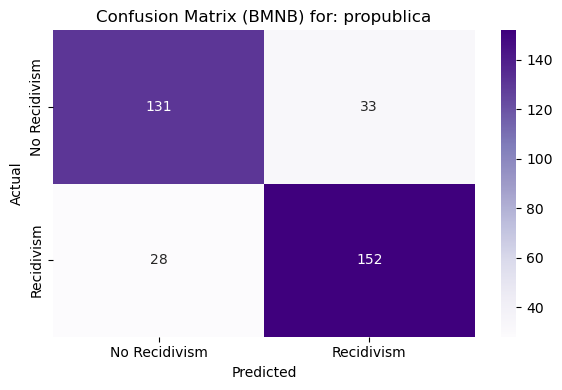

In [245]:
propublica_df = pd.read_csv("propublica_data_for_fairml.csv")
X, y, s, dataset_P = preprocess_data(propublica_df, 'propublica')
run_bmnb(X, y, s, dataset_P)

✅ After SMOTEENN - X shape: (4590, 14)
[0 1]
framingham

📊 Performance Metrics for: framingham
Accuracy : 0.6350762527233116
Precision: 0.8533724340175953
Recall   : 0.5052083333333334
F1 Score : 0.6346782988004362

📊 Group-specific Metrics for: framingham
Group 0: {'TPR (Recall)': 0.534, 'FPR': 0.158, 'PPR': 0.372, 'Support': 468}
Group 1: {'TPR (Recall)': 0.481, 'FPR': 0.129, 'PPR': 0.371, 'Support': 450}

📏 Fairness Metrics:
Equal Opportunity Difference (EOD): -0.053
Equal Mis-Opportunity Difference (EMOD): -0.029
Statistical Parity Difference (SPD): -0.001
Disparate Impact (DI): 0.997

📐 Bias Index and Fairness Score for : framingham
Bias Index (BI): 0.021
Fairness Score (FS): 0.979

📄 Classification Report for: framingham
              precision    recall  f1-score   support

   No Stroke       0.51      0.85      0.64       342
      Stroke       0.85      0.51      0.63       576

    accuracy                           0.64       918
   macro avg       0.68      0.68      0.64  

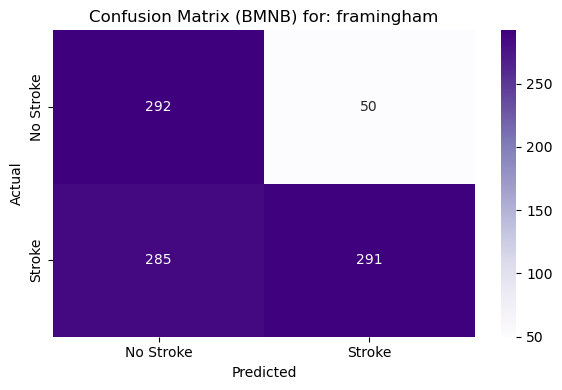

In [246]:


framingham_df = pd.read_csv("framingham.csv")
X, y, s, dataset_F = preprocess_data(framingham_df, 'framingham')
run_bmnb(X, y, s, dataset_F)


✅ After SMOTEENN - X shape: (21858, 13)
[0 1]
adult

📊 Performance Metrics for: adult
Accuracy : 0.7143183897529735
Precision: 0.8686700055648303
Recall   : 0.6064491064491064
F1 Score : 0.7142530313429422

📊 Group-specific Metrics for: adult
Group 0: {'TPR (Recall)': 0.792, 'FPR': 0.219, 'PPR': 0.411, 'Support': 1107}
Group 1: {'TPR (Recall)': 0.575, 'FPR': 0.071, 'PPR': 0.411, 'Support': 3265}

📏 Fairness Metrics:
Equal Opportunity Difference (EOD): -0.217
Equal Mis-Opportunity Difference (EMOD): -0.148
Statistical Parity Difference (SPD): 0.000
Disparate Impact (DI): 1.000

📐 Bias Index and Fairness Score for : adult
Bias Index (BI): 0.091
Fairness Score (FS): 0.909

📄 Classification Report for: adult
              precision    recall  f1-score   support

       <=50K       0.61      0.87      0.71      1798
        >50K       0.87      0.61      0.71      2574

    accuracy                           0.71      4372
   macro avg       0.74      0.74      0.71      4372
weighted avg  

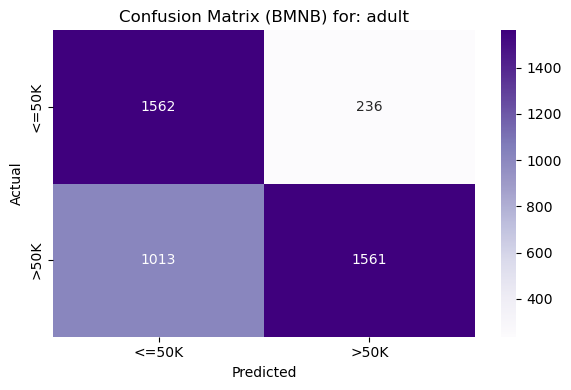

In [247]:
adult_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

# Load and assign column names
adult_df = pd.read_csv(adult_url, header=None, names=column_names, skipinitialspace=True)
X, y, s, dataset_A= preprocess_data(adult_df, "adult")
run_bmnb(X, y, s, dataset_A)
